# Estimate the posterior probability of an interaction based on observed ERGs

Quantify whether there is an interaction or not between two genes in Drosophila melanogaster PD models

 

In [1]:
import os.path
import pandas as pd
import yaml
import seaborn as sns
import arviz as az
import numpy as np
from utils import (
   load_trace,
   min_distance_to_interval
)
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
all_data=pd.read_csv("processed/genetic_interactions_database.csv")
with open("processed/gene_pairs.yaml") as handle:
    gene_pairs=yaml.load(handle, yaml.SafeLoader)

In [4]:
all_data

,Unnamed: 0,Date_recording,Genotype,Double,metric,metric_control,metric_norm,WT,metric_inv
0,0,2022-01-19,Auxillin[KO]_+,False,-2.1637,-4.439283,0.487398,False,2.1637
1,1,2022-03-02,Auxillin[KO]_+,False,-5.7695,-5.317360,1.085031,False,5.7695
2,2,2022-03-02,Auxillin[KO]_+,False,-4.5149,-5.317360,0.849087,False,4.5149
3,3,2022-03-17,Auxillin[KO]_+,False,-5.5708,-5.175567,1.076365,False,5.5708
4,4,2022-03-17,Auxillin[KO]_+,False,-4.3566,-5.175567,0.841763,False,4.3566
...,...,...,...,...,...,...,...,...,...
4321,4321,2025-08-21,Tango14[KO]_+;Park[KO]_+,True,-4.7887,-4.037671,1.186005,False,4.7887
4322,4322,2025-08-21,Tango14[KO]_+;Park[KO]_+,True,-4.4491,-4.037671,1.101897,False,4.4491
4323,4323,2025-08-21,Tango14[KO]_+;Park[KO]_+,True,-5.2980,-4.037671,1.312142,False,5.2980
4324,4324,2025-08-21,Tango14[KO]_+;Park[KO]_+,True,-4.3428,-4.037671,1.075570,False,4.3428


In [5]:
mean_depol=all_data.groupby("Genotype").agg({"metric_norm": np.mean}).reset_index()
double_index=all_data[["Genotype", "Double"]].drop_duplicates()
assert (double_index.value_counts("Genotype")==1).all()
mean_depol=mean_depol.merge(double_index, on="Genotype")

/tmp/ipykernel_1346999/3332494727.py:1: FutureWarning: The provided callable <function mean at 0x770058f37560> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  mean_depol=all_data.groupby("Genotype").agg({"metric_norm": np.mean}).reset_index()


In [6]:
prefix="2025-09-17"
# prefix="2024-06-27"
# prefix="2024-05-13"
out_folder=f"{prefix}_models/"


In [7]:
records=[]
delta_z={}
metric="metric_norm"
for pair_id in gene_pairs.keys():
    genes=gene_pairs[pair_id]
    fname = f"{out_folder}/model_{str(pair_id).zfill(3)}.nc"
    if not os.path.exists(fname):
        continue
    trace = load_trace(f"{out_folder}/model_{str(pair_id).zfill(3)}.pkl")
    
    with open(f"{out_folder}/model_{str(pair_id).zfill(3)}.txt", "r") as handle:
        genes=handle.read().split("\n")
    
    data=all_data.loc[all_data["Genotype"].isin(genes )]
    data_hist=all_data.loc[all_data["Genotype"].isin(genes  + ["W1118"])]

    hdi=az.hdi(trace,var_names=["interaction"], hdi_prob = 0.95).to_array().values.flatten().tolist()

    # import ipdb; ipdb.set_trace()

    expected_dm=mean_depol.loc[mean_depol["Genotype"]==genes[0], "metric_norm"].item()*mean_depol.loc[mean_depol["Genotype"]==genes[1], "metric_norm"].item()

    dz=all_data.loc[all_data["Genotype"]==genes[2], "metric_norm"].values - expected_dm
    delta_z[pair_id]=dz
    
    
    records.append((
        pair_id,
        hdi[0],
        hdi[1],
        expected_dm,
        np.mean(dz),
    ))

In [8]:
data=pd.DataFrame(records, columns=["pair_id", "hdi0", "hdi1", "expected", "mean(observed-expected)"])

In [9]:
pair_ids=data["pair_id"].values

In [10]:
for id in [pair for pair in gene_pairs if not pair in pair_ids]:
    print(f"Data not available: {gene_pairs[id]}")

In [11]:
# format gene names
def remove_gene_suffix(gene):
    return gene.replace("_+", "").replace("_y", "")
    
    
data["single_mutant_0"]=[remove_gene_suffix(gene_pairs[pair_id][0]) for pair_id in data["pair_id"]]
data["single_mutant_1"]=[remove_gene_suffix(gene_pairs[pair_id][1]) for pair_id in data["pair_id"]]

In [12]:
good_names=pd.read_csv("raw/250911_list_correct_names.txt", sep =" ")
good_names=good_names.loc[~good_names["correct_name"].isna()]
good_names={remove_gene_suffix(row["original_name"]): remove_gene_suffix(row["correct_name"]) for _, row in good_names.iterrows()}


In [13]:
data["single_mutant_0"].unique()

array(['Auxillin[KO]', 'CG32000[KO]', 'CG5010[KO]', 'CG5608[KO]',
       'Coq2[KO]', 'Dj1a[KO];DJ1b[KO]', 'eIF4G[KO]', 'GBA[KO]', 'Gdh[KO]',
       'iPLA2-VIA[KO]', 'Loqs[KO]', 'Lrrk[KO]', 'nutcracker[KO]',
       'Omi[KO]', 'Park[KO]', 'Pink1[KO]', 'Punch[KO]', 'Rab39[KO]',
       'Rme8[KO]', 'Synj[KO]', 'Tango14[KO]', 'vham8,9[KO]', 'Vps13[KO]'],
      dtype=object)

In [14]:
data["single_mutant_0"]=[good_names[gene] if gene in good_names else gene for gene in data["single_mutant_0"]]
data["single_mutant_1"]=[good_names[gene] if gene in good_names else gene for gene in data["single_mutant_1"]]

In [15]:
good_names

{'Auxillin[KO]': 'auxilin[KO-WS/+]',
 'CG32000[KO]': 'anne[KO-WS/+]',
 'CG5010[KO]': 'Chchd2[KO-WS/y]',
 'CG5608[KO]': 'VAC14[KO-WS/+]',
 'Coq2[KO]': 'Coq2[KO-WS/+]',
 'Dj1a[KO];DJ1b[KO]': 'Dj1a[KO-WS/+];Dj1b[KO-WS/+]',
 'eIF4G[KO]': 'eIF4G[KO-WS/+]',
 'GBA[KO]': 'gba[KO-w+/+]',
 'Gdh[KO]': 'Gdh[KO-WS/+]',
 'iPLA2-VIA[KO]': 'iPLA2-VIA[KO-WS/+]',
 'Loqs[KO]': 'loqs[KO-WS/+]',
 'Lrrk[KO]': 'Lrrk[KO-WS/+]',
 'nutcracker[KO]': 'nutcracker[KO-WS/+]',
 'Omi[KO]': 'omi[KO-WS/+]',
 'Park[KO]': 'park[1/+]',
 'Pink1[KO]': 'Pink1[KO-WS/y]',
 'Punch[KO]': 'Punch[KO-WS/+]',
 'Rab39[KO]': 'Rab39[KO-WS/y]',
 'Rme8[KO]': 'Rme-8[KO-WS/+]',
 'Synj[KO]': 'Synj[KO-WS/+]',
 'Tango14[KO]': 'Tango14[KO-WS/+]',
 'vham8,9[KO]': 'VhaM8.9[KO-WS/+]',
 'Vps13[KO]': 'Vps13[KO-WS/+]',
 'Vps35[KO]': 'Vps35[KO-WS/+]'}

In [16]:
data["dist_0"]=[min_distance_to_interval((row["hdi0"], row["hdi1"]), 0)[0] for _, row in data.iterrows()]

In [17]:
data["side"]=[min_distance_to_interval((row["hdi0"], row["hdi1"]), critical_value=0)[1] for _, row in data.iterrows()]

In [18]:
data.to_csv(f"processed/{prefix}_output.csv")

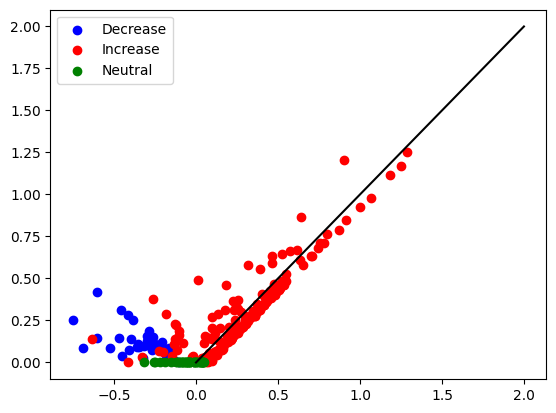

In [ ]:
plt.scatter(
    data.loc[data["side"]=="decrease", "mean(observed-expected)"],
    data.loc[data["side"]=="decrease", "dist_0"],
    color="b", label="Decrease"
)
plt.scatter(
    data.loc[data["side"]=="increase", "mean(observed-expected)"],
    data.loc[data["side"]=="increase", "dist_0"],
    color="r", label="Increase"
)

plt.scatter(
    data.loc[data["side"]=="neutral", "mean(observed-expected)"],
    data.loc[data["side"]=="neutral", "dist_0"],
    color="g", label="Neutral"
)
plt.legend()
plt.plot([0,2], [0,2], color="k")
plt.savefig(f"figures/{prefix}_correlation.png")

In [20]:
mutants=list(sorted(set(data["single_mutant_0"].unique().tolist() + data["single_mutant_1"].unique().tolist())))
import itertools
data_plot = np.zeros((len(mutants), len(mutants)))
data_plot[:]=np.nan
for mutant1, mutant2 in itertools.combinations(mutants, 2):
    i=mutants.index(mutant1)
    j=mutants.index(mutant2)
    dist=data.loc[
       ((data["single_mutant_0"]==mutant1)&(data["single_mutant_1"]==mutant2))|\
       ((data["single_mutant_1"]==mutant1)&(data["single_mutant_0"]==mutant2)),
        "dist_0"
    ]
    if dist.shape[0]==1:
        dist=dist.item()
        data_plot[i,j]=dist
        data_plot[j, i]=dist
    else:
        print(f"Pair not available: {mutant1}, {mutant2}")

data_plot=pd.DataFrame(data_plot)
data_plot.columns=mutants
data_plot.index=mutants


In [21]:
data_plot.to_csv(f"processed/{prefix}_genetic_interactions_dist_95hdi.csv")

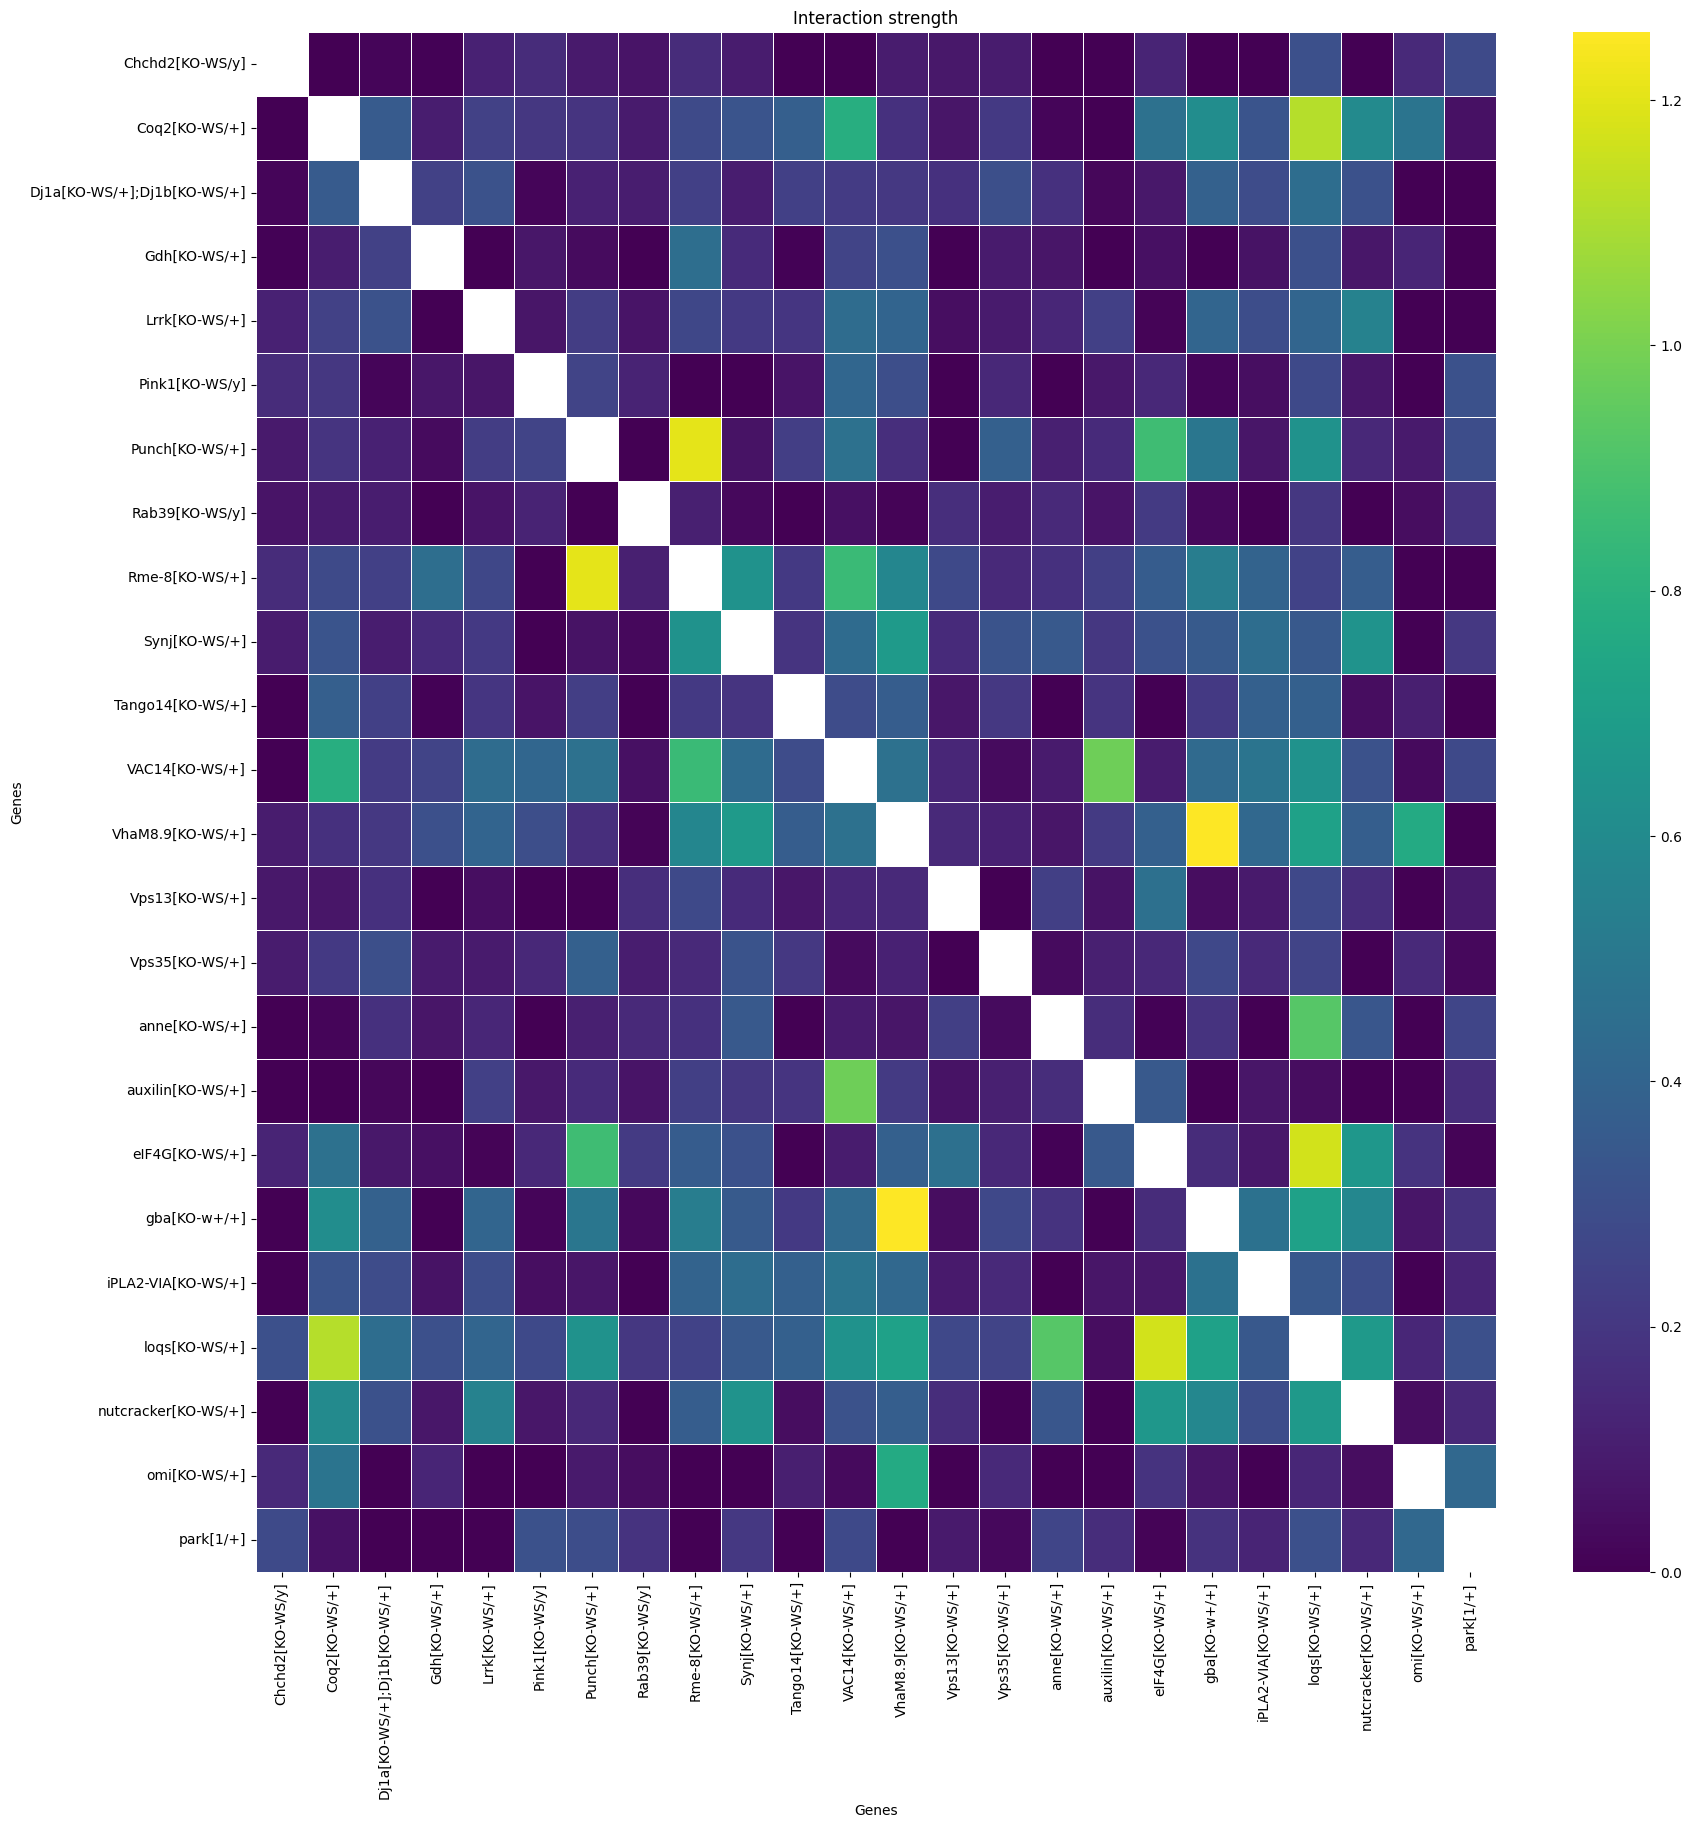

In [ ]:
# Create a heatmap using seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(data_plot, annot=False, cmap='viridis', fmt=".1f", linewidths=.5)
plt.title('Interaction strength')
plt.xlabel('Genes')
plt.ylabel('Genes')
plt.savefig(f"figures/{prefix}_interaction_strength.png")
plt.savefig(f"figures/{prefix}_interaction_strength.svg")

In [23]:
[gene_pairs[pair_id] for pair_id in data.loc[data["hdi0"]>=1, "pair_id"]]

[['Coq2[KO]_+', 'Loqs[KO]_+', 'Loqs[KO]_+;Coq2[KO]_+'],
 ['eIF4G[KO]_+', 'Loqs[KO]_+', 'Loqs[KO]_+;;eIF4G[KO]_+'],
 ['GBA[KO]_+', 'vham8,9[KO]_+', 'GBA[KO]_vham8,9[KO]'],
 ['Punch[KO]_+', 'Rme8[KO]_+', 'Punch[KO]_Rme8[KO]']]

In [24]:
genotypes=all_data["Genotype"].unique()
# genotypes

In [26]:
sms=["Pink1[KO]_y","Park[KO]_+"]
genes=[genotype for genotype in genotypes if genotype in sms or all(gene in genotype for gene in sms)]
data_hist=all_data.loc[all_data["Genotype"].isin(genes  + ["W1118"])]
fig=px.histogram(data_hist, x=metric, color="Genotype", nbins=100)
fig.show()

In [37]:
all_data["Genotype"].unique()

array(['Auxillin[KO]_+', 'Auxillin[KO]_iPLA2-VIA[KO]',
       'Auxillin[KO]_Park[KO]', 'CG32000[KO]_+', 'CG5010[KO]_y',
       'CG5010[KO]_y;;;CG32000[KO]_+', 'CG5010[KO]_y;;;eIF4G[KO]_+',
       'CG5010[KO]_y;;Auxillin[KO]_+', 'CG5010[KO]_y;;CG5608[KO]_+',
       'CG5010[KO]_y;;Coq2[KO]_+', 'CG5010[KO]_y;;GBA[KO]_+',
       'CG5010[KO]_y;;Gdh[KO]_+', 'CG5010[KO]_y;;iPLA2-VIA[KO]_+',
       'CG5010[KO]_y;;Lrrk[KO]_+', 'CG5010[KO]_y;;nutcracker[KO]_+',
       'CG5010[KO]_y;;Omi[KO]_+', 'CG5010[KO]_y;;Park[KO]_+',
       'CG5010[KO]_y;;vham8,9[KO]_+', 'CG5010[KO]_y;Loqs[KO]_+',
       'CG5010[KO]_y;Punch[KO]_+', 'CG5010[KO]_y;Rme8[KO]_+',
       'CG5010[KO]_y;Synj[KO]_+', 'CG5010[KO]_y;Tango14[KO]_+',
       'CG5010[KO]_y;Vps35[KO]_+', 'CG5010[KO]_y;Dj1a[KO]_+;DJ1b[KO]_+',
       'CG5608[KO]_+', 'CG5608[KO]_nutcracker[KO]', 'CG5608[KO]_Park[KO]',
       'Coq2[KO]_+', 'Coq2[KO]_iPLA2-VIA[KO]', 'Coq2[KO]_nutcracker[KO]',
       'Coq2[KO]_Park[KO]', 'Dj1a[KO]_+;Auxillin[KO]_DJ1b[KO]',
     